# Librerias

In [1]:
import fastai.tabular.all as ft
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Indice 

- [Procesamiento de datos](#procesing)
- [Modelo](#model)
- [Predicción](#predict)

In [74]:
!ls

COVID_predict.ipynb		    diabetes.csv    models
Practica_BeforePredict_Covid.ipynb  faces	    mydata
archive				    images	    rossmann-store-sales.zip
data				    latestdata.csv


In [2]:
data_covid =pd.read_csv('latestdata.csv', low_memory=True, parse_dates=['date_death_or_discharge','date_onset_symptoms','date_admission_hospital','date_confirmation','travel_history_dates'])
#data_covid

/opt/conda/envs/fastai/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,2,12,13,15,16,17,19,20,21,22,24,25,26,27,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
tmp =  data_covid[data_covid['date_onset_symptoms'].notnull()]

In [5]:
tmp['date_onset_symptoms']

53         08.02.2020
55         01.02.2020
335        30.01.2020
365        14.02.2020
446        11.02.2020
              ...    
2500872    16.04.2020
2500873    17.04.2020
2500875    16.04.2020
2500876    19.04.2020
2500877    18.04.2020
Name: date_onset_symptoms, Length: 261599, dtype: object

Claramente no esta haciendo la conversión por lo que eliminaremos esta columna

<a id="procesing"><strong><h1>Procesamiento de datos</h1></strong></a>


In [78]:
data_covid.head().T

,0,1,2,3,4
ID,000-1-1,000-1-10,000-1-100,000-1-1000,000-1-10000
age,NaN,78,61,NaN,NaN
sex,male,male,female,NaN,NaN
city,Shek Lei,Vo Euganeo,NaN,Zhengzhou City,Pingxiang City
province,Hong Kong,Veneto,NaN,Henan,Jiangxi
country,China,Italy,Singapore,China,China
latitude,22.365,45.2977,1.35346,34.6293,27.5136
longitude,114.134,11.6584,103.815,113.468,113.903
geo_resolution,point,point,admin0,admin2,admin2
date_onset_symptoms,NaN,NaN,NaN,NaN,NaN


A partir del despliegue de los datos anterior, podemos hacer una primer preselección de columnas de trabajo para descartar algunas que serán intrascendentes. 
Podemos descartar:
- **_source_**: El origen de los datos es irrelevante para el modelo
- **_ID_**: El ID asociado al paciente no parce relevante
- **_admin_id_**: El id asociado al admin es irrelevante para el modelo
- **_additional_information_**: Si se tratara de analisis de lenguaje, esto nos serviria pero para este caso. Es irrelevante.
- **_notes_for_discussion_**: Únicamente contamos con 640 registros, a juzgar por el almacenado de "additional_information" pienso que también se ocupa de procesamiento de lenguaje para tratar con esta columna, por lo tanto la eliminamos. 

In [79]:
#Revisar el total de registros faltantes 
data_covid.isna().sum()      

ID                                0
age                         2098293
sex                         2096154
city                         977681
province                     452664
country                         115
latitude                         61
longitude                        61
geo_resolution                   61
date_onset_symptoms         2414712
date_admission_hospital     2560100
date_confirmation            108489
symptoms                    2674259
lives_in_Wuhan              2671973
travel_history_dates        2673700
travel_history_location     2667089
reported_market_exposure    2675242
additional_information      2630456
chronic_disease_binary            0
chronic_disease             2676096
source                       566964
sequence_available          2676299
outcome                     2368929
date_death_or_discharge     2673163
notes_for_discussion        2675671
location                    2662935
admin3                      2595877
admin2                      

In [3]:
data_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676311 entries, 0 to 2676310
Data columns (total 33 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   ID                        object        
 1   age                       object        
 2   sex                       object        
 3   city                      object        
 4   province                  object        
 5   country                   object        
 6   latitude                  float64       
 7   longitude                 float64       
 8   geo_resolution            object        
 9   date_onset_symptoms       object        
 10  date_admission_hospital   object        
 11  date_confirmation         object        
 12  symptoms                  object        
 13  lives_in_Wuhan            object        
 14  travel_history_dates      object        
 15  travel_history_location   object        
 16  reported_market_exposure  object        
 17  addition

<AxesSubplot:>

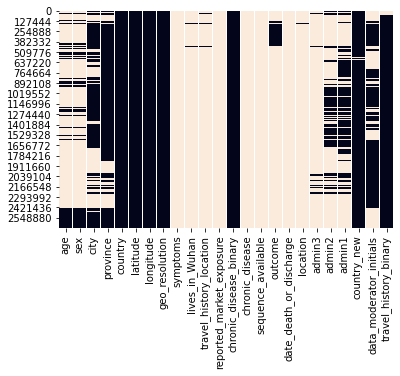

In [83]:
# ESTADO DE LOS DATOS
sns.heatmap(data_covid.isnull(), cbar=False)

Tenemos demasiados datos faltantes así como un tipo de dato con el que el modelo no puede trabajar

Antes de cambiar el tipo de dato, onehotencodear si es necesario y cualquier otro preprocesamiento, haremos uso de una matriz de correlación para ver que variables son importantes. 

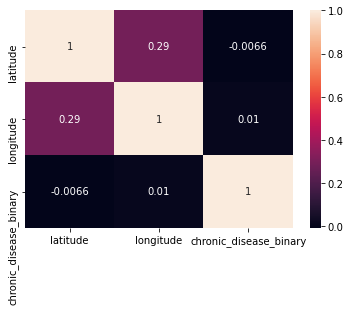

<Figure size 2160x1872 with 0 Axes>

In [84]:
#correlation_mat = heart_failure.corr().unstack()
R=data_covid.corr()
#print(correlation_mat)
sns.heatmap(R, annot = True)
plt.figure(figsize=(30,26))
plt.show()

¿Qué paso? Recordemos que tenemos varias variables que no son numericas por lo que primero debemos hacer una conversión. 

Ahora vamos a revisar columna a columna para determinar el tipo de dato y si se trata de una variable continua o categoríca

In [3]:
# Primero, seleccionamos todos los registros que tienen outcome, para trabajar
data_covid = data_covid[data_covid['outcome'].notnull()]

In [4]:
data_covid.age.unique()
# age = continua

array([nan, '78', '61', '28', '56', '79', '26', '25', '40', '43', '29',
       '71', '68', '1', '35', '36', '32', '30', '41', '58', '38', '88',
       '22', '55', '12', '54', '57', '24', '44', '95', '39', '46', '27',
       '66', '51', '50-59', '80-89', '42', '7', '33', '4', '60', '20',
       '94', '38-68', '63', '0.5', '53', '52', '9', '31', '60-69',
       '20-29', '40-49', '70-79', '47', '50', '37', '76', '62', '70',
       '65', '21', '64', '23', '45', '87', '2', '67', '22-80', '19-77',
       '21-72', '82', '90-99', '73', '92', '49', '48', '8', '16', '0.25',
       '77', '34', '72', '85', '69', '81', '15-88', '89', '75', '80',
       '86', '84', '74', '59', '18', '15', '17', '19', '14', '20-57',
       '0.75', '13', '10', '11', '91', '90', '0', '83', '6', '3', '99',
       '96', '28-35', 39.0, 44.0, 54.0, 45.0, 30.0, 33.0, 50.0, 20.0,
       53.0, 46.0, 31.0, 35.0, 80.0, 72.0, 24.0, 37.0, 27.0, 65.0, 28.0,
       40.0, 34.0, 36.0, 41.0, 38.0, 57.0, 32.0, 52.0, 47.0, 21.0, 55.0,
 

In [5]:
# Remplazamos todos los valores "extraños" por algo con lo que podamos trabajar
data_covid.age.replace({"0.1": '0', "0.2": '0', "0.25": '0', "0.3": '0', "0.4": '0', "0.5": '1',
                   "0.6": '1', "0.7": '1', "0.75": '1', "0.9": '1', "1.5": '2', "15-88": '52',
                   "19-77": '48', "2.5": '3', "20-29": '15', "20-57": '39', "21-72": '47',
                   "22-80": '51', "28-35": '32', "29.6": '30', "3.5": '4', "38-68": '53',
                    "40-49": '45', "50-59": '55', "54.9": '55', "60-69": '65', "70-79": '75', 
                   "80-": '80', "80-89": '85', "90-99": '95'}, inplace=True)

In [6]:
data_covid.age = data_covid.age.astype(float)

In [7]:
data_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307382 entries, 0 to 673607
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ID                        307382 non-null  object        
 1   age                       34435 non-null   float64       
 2   sex                       38115 non-null   object        
 3   city                      263094 non-null  object        
 4   province                  306481 non-null  object        
 5   country                   307380 non-null  object        
 6   latitude                  307382 non-null  float64       
 7   longitude                 307382 non-null  float64       
 8   geo_resolution            307382 non-null  object        
 9   date_onset_symptoms       3543 non-null    object        
 10  date_admission_hospital   301 non-null     object        
 11  date_confirmation         307308 non-null  object        
 12  sy

In [15]:
#my_age = list(data_covid.loc[:, 'age'])
#my_ages =  list(map(float, my_age))
#data_covid.loc[:, 'age'] = my_ages

In [8]:
data_covid.sex.unique()
#sexo # categorica

array(['male', 'female', nan], dtype=object)

In [9]:
data_covid.city.unique()
#ciudad #categorica

array(['Shek Lei', 'Vo Euganeo', nan, ..., 'Habana Vieja', 'Eddy County',
       'Chittenden County'], dtype=object)

In [11]:
data_covid.province.unique()
#provincia # categorica

In [20]:
data_covid.country.unique()
#pais # categorica

In [93]:
data_covid.latitude.unique()
#latitud # continua

In [94]:
data_covid.longitude.unique()
#longitud #continua

In [48]:
data_covid['geo_resolution'].unique
#geo #la quitamos dados los datos que almacena

In [14]:
data_covid.symptoms.unique()
#sintomas #categorica # la quitamos dada la manera de almacenamiento que usa
# parece algo más para procesamiento de lenguaje .-. 

In [15]:
data_covid['lives_in_Wuhan'].unique()
#wuhan # categorica

array([nan, 'no', 'yes'], dtype=object)

In [50]:
data_covid['lives_in_Wuhan'] = data_covid['lives_in_Wuhan'].astype(bool)

In [18]:
data_covid['travel_history_location'].unique()
#travel # categorica # la quitamos dado el tipo de almacenamiento

In [23]:
data_covid['reported_market_exposure'].unique()
#report # categorica
#Tal vez podemos arreglarla

array([nan, 'no', 'na', 'yes, retailer in the seafood wholesale market'],
      dtype=object)

In [25]:
# Remplazamos todos los valores "extraños" por algo con lo que podamos trabajar
data_covid['reported_market_exposure'].replace({'na': np.nan, 
                                               'yes, retailer in the seafood wholesale market': 'yes'}, inplace=True)

In [26]:
data_covid['reported_market_exposure'].unique()

array([nan, 'no', 'yes'], dtype=object)

In [27]:
data_covid['reported_market_exposure'] = data_covid['reported_market_exposure'].astype(bool)

In [28]:
data_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307382 entries, 0 to 673607
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ID                        307382 non-null  object        
 1   age                       34435 non-null   float64       
 2   sex                       38115 non-null   object        
 3   city                      263094 non-null  object        
 4   province                  306481 non-null  object        
 5   country                   307380 non-null  object        
 6   latitude                  307382 non-null  float64       
 7   longitude                 307382 non-null  float64       
 8   geo_resolution            307382 non-null  object        
 9   date_onset_symptoms       3543 non-null    object        
 10  date_admission_hospital   301 non-null     object        
 11  date_confirmation         307308 non-null  object        
 12  sy

In [29]:
data_covid['chronic_disease_binary'].unique()
#categorica 

array([False,  True])

In [31]:
data_covid['chronic_disease'].unique()
#cronica # categorica # no necesaria dado la manera de almacenar

In [102]:
data_covid['sequence_available'].unique()
#secuencia
# Eliminamos esta columna dado su manera extraña de almacenamiento de datos

In [32]:
data_covid['outcome'].unique()
#y
# podemos arreglarla para reducir las categorias a predecir

array(['critical condition, intubated as of 14.02.2020', 'death',
       'discharge', 'discharged', 'Discharged',
       'Discharged from hospital', 'not hospitalized', 'recovered',
       'recovering at home 03.03.2020', 'released from quarantine',
       'severe', 'stable', 'died', 'Death', 'dead',
       'Symptoms only improved with cough. Currently hospitalized for follow-up.',
       'treated in an intensive care unit (14.02.2020)', 'Alive', 'Dead',
       'Recovered', 'Stable', 'Died', 'Deceased', 'stable condition',
       'Under treatment', 'Critical condition', 'Receiving Treatment',
       'severe illness', 'unstable', 'critical condition', 'Hospitalized',
       'Migrated', 'Migrated_Other',
       'https://www.mspbs.gov.py/covid-19.php'], dtype=object)

In [33]:
data_covid.outcome.replace({'critical condition, intubated as of 14.02.2020': 'critical',
 'death': 'dead',
 'discharged': 'discharge',
 'Discharged': 'discharge', 
'Discharged from hospital': 'discharge',
'not hospitalized': 'discharge',
'recovering at home 03.03.2020': 'recovered',
'released from quarantine': 'recovered',
'severe': 'critical',
'stable': 'recovered',
'died': 'dead',
'Death': 'dead',
'Symptoms only improved with cough. Currently hospitalized for follow-up.': 'hospitalized',
'treated in an intensive care unit (14.02.2020)': 'critical',
'Alive': 'recovered',
'Dead': 'dead',
'Recovered': 'recovered',
'Stable': 'recovered',
'Died': 'dead',
'Deceased': 'dead',
'stable condition': 'recovered',
'Under treatment': 'discharge',
'Critical condition': 'critical',
'Receiving Treatment': 'discharge',
'severe illness': 'critical',
'unstable': 'critical',
'critical condition': 'critical',
'Hospitalized': 'hospitalized',
'Migrated': 'hospitalized',
'Migrated_Other': 'hospitalized',
'https://www.mspbs.gov.py/covid-19.php': np.nan }, inplace=True)

In [36]:
data_covid['outcome'].unique()

array(['critical', 'dead', 'discharge', 'recovered', 'hospitalized', nan],
      dtype=object)

In [38]:
data_covid['date_death_or_discharge'].unique()
#continua
# Las fechas me han causado problemas, por lo tanto las eliminamos

In [40]:
data_covid.location.unique() 
#categorica # Mucho texto, por lo tanto la eliminamos

In [42]:
data_covid.admin3.unique()
#categorica #no necesaria dada la falta de datos

In [108]:
data_covid.admin2.unique()
#admin2 #categorica #no necesaria dada la falta de datos

In [44]:
data_covid.admin1.unique()
#admin1 #categorica #entre admin1, 2 y 3 admin1 es la que cuenta con más datos, por lo tanto 
# la dejamos para el modelo, aunque tal vez la quitemos

In [45]:
data_covid['country_new'].unique()
#pais #categorica

array(['China', 'Italy', 'Singapore', 'South Korea', 'Switzerland',
       'San Marino', 'Australia', 'Japan', 'Nepal', 'Malaysia',
       'Thailand', 'Canada', 'Germany', 'Philippines', 'France',
       'United States', nan, 'Egypt', 'Brazil', 'Vietnam',
       'United Arab Emirates', 'Spain', 'Iran', 'Zimbabwe', 'Angola',
       'Burkina Faso', 'Cabo Verde', 'Cameroon',
       'Central African Republic', 'Djibouti', 'Eritrea', 'Eswatini',
       'Ethiopia', 'Gabon', 'Guinea-Bissau', 'Guinea', 'Mozambique',
       'Sudan', 'Tanzania', 'Togo', 'Zambia', 'Ghana', 'Gambia', 'Kenya',
       'Nigeria', 'India', 'Romania', 'Bahamas', 'Paraguay', 'Cuba'],
      dtype=object)

In [46]:
data_covid['data_moderator_initials'].unique()
#moderador #categorica 
#Búsque en el github alguna explicación de las iniciales pero no tuve suerte
#por lo tanto la quitamos

array([nan, 'SL', 'TR', 'NRF, DSC'], dtype=object)

In [47]:
data_covid['travel_history_binary'].unique()
#viajeh #categorica

array([nan, False, True], dtype=object)

In [51]:
data_covid['travel_history_binary'] = data_covid['travel_history_binary'].astype(bool)

Quitamos del dataset todas las columnas marcadas como inncesesarias

In [55]:
data_covid = data_covid.loc[:, ['age', 'sex', 'city', 'province',
                               'country', 'latitude', 'longitude',
                               'reported_market_exposure', 'chronic_disease_binary', 'outcome',
                               'admin1', 'country_new', 'travel_history_binary']]
# Me marcaba que no soportaba 'lives_in_Wuhan' por lo tanto la quite

A partir de lo anterior podemos hacer una clasificación de nuestras variables

In [57]:
# Variables categoricas, nombres
cat_names = ['age', 'sex', 'city',
             'province', 'country',
            'chronic_disease_binary',
            'admin1', 'country_new', 
            'travel_history_binary']
# Variables continuas, nombres
cont_names = ['age', 'latitude', 'longitude'] 
# Variable a predecir
y_names = ['outcome']

In [58]:
# Recordemos que anteriormente hicimos unas modificaciones en outcome, una de ellas fue cambiar 
# los registros que tenian enlaces por na por lo tanto volvemos a seleccionar únicamente los que si
# cuentan con registro
data_covid = data_covid[data_covid['outcome'].notnull()]

Volvemos a ver el estado de los datos con los que vamos a trabajar

<AxesSubplot:>

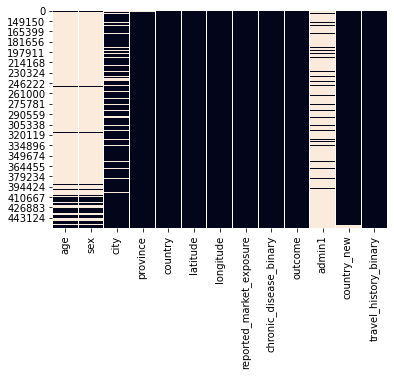

In [77]:
# Estado de los datos
sns.heatmap(data_covid.isnull(), cbar=False)

Aunque siguen faltando datos, no hay mucho que ver con el primer mapa de calor

<a id="model"><strong><h1>Modelo</h1></strong></a>


In [59]:
len(data_covid)

307256

In [60]:
X = list(range(len(data_covid)))

In [61]:
valid_cut = len(data_covid) - 40000

In [62]:
# df corresponde al dataframe
# procs es como las transformaciones
# cat_names son los nombres de mis variables categoricas
# cont_names son los nombres de mis variables continuas
# y_names es lo que voy a predecir
# splits como dividir en entrenamiento y validación
# FillMissing rellena mis datos faltantes 
src = ft.TabularPandas(data_covid,
                      procs = [ft.Categorify, ft.FillMissing],
                      cat_names = cat_names,
                      cont_names = cont_names,
                      y_names = y_names, 
                       y_block = ft.CategoryBlock,
                      splits = (X[:valid_cut], X[valid_cut:])
                      )

In [63]:
dls = src.dataloaders(bs=1024)

In [64]:
batch = dls.one_batch()

In [65]:
# Variables categoricas, continuas y dependientes
cat, cont, y = batch

In [66]:
cat.shape

torch.Size([1024, 10])

In [67]:
cont.shape

torch.Size([1024, 3])

In [68]:
y.shape

torch.Size([1024, 1])

In [69]:
learn = ft.tabular_learner(dls, opt_func=ft.ranger, metrics=ft.accuracy)

In [70]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(99, 21)
    (1): Embedding(3, 3)
    (2): Embedding(2351, 124)
    (3): Embedding(214, 32)
    (4): Embedding(52, 15)
    (5): Embedding(3, 3)
    (6): Embedding(98, 21)
    (7): Embedding(49, 14)
    (8): Embedding(3, 3)
    (9): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(242, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=242, out_features=200, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=200, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=5, bias=True)
    )
  )
)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.013182567432522774)

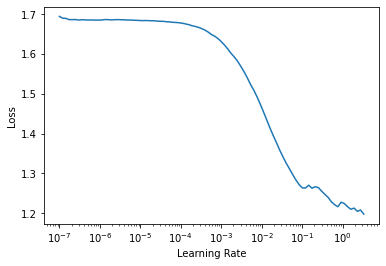

In [71]:
learn.lr_find()

In [72]:
learn.fit_one_cycle(20, 1e-3, div=2, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,time
0,0.671124,0.402098,0.847425,00:05
1,0.631033,0.398118,0.844125,00:05
2,0.629552,0.394407,0.843325,00:05
3,0.626850,0.392497,0.844675,00:05
4,0.628147,0.390667,0.846550,00:05
5,0.626469,0.404031,0.841900,00:05
6,0.627420,0.404039,0.844125,00:05
7,0.625381,0.400823,0.847400,00:05
8,0.624465,0.393278,0.850300,00:04
9,0.624724,0.398802,0.849500,00:05


In [73]:
learn = ft.tabular_learner(dls,
                           emb_szs = {'age':16, 'sex':16, 'city':16, 'province':16, 'country':16, 'latitude':16,
       'longitude':16, 'chronic_disease_binary':16,
        'admin1':16, 'country_new':16, 'travel_history_binary':16},
                           layers = [256, 128, 128], 
                           config = ft.tabular_config(act_cls=nn.LeakyReLU(inplace=True)),
                          opt_func = ft.ranger, 
                          metrics = ft.accuracy)

In [75]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(99, 16)
    (1): Embedding(3, 16)
    (2): Embedding(2351, 16)
    (3): Embedding(214, 16)
    (4): Embedding(52, 16)
    (5): Embedding(3, 16)
    (6): Embedding(98, 16)
    (7): Embedding(49, 16)
    (8): Embedding(3, 16)
    (9): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=150, out_features=256, bias=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=256, out_features=128, bias=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (2): LinBnDrop(
      (0): BatchNorm1d(128, eps=

In [74]:
learn.fit_one_cycle(20, 1e-3, div=2, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,time
0,0.667149,0.399756,0.850625,00:05
1,0.631576,0.379830,0.857475,00:05
2,0.627017,0.384818,0.850200,00:05
3,0.626077,0.384280,0.850500,00:05
4,0.625773,0.413674,0.839025,00:05
5,0.630175,0.390041,0.843625,00:05
6,0.625898,0.386654,0.851700,00:05
7,0.624943,0.401495,0.839625,00:05
8,0.624482,0.419989,0.839450,00:05
9,0.625295,0.442385,0.830825,00:05


<a id="predict"><strong><h1>Predicción</h1></strong></a>


In [79]:
len(data_covid)

307256

In [80]:
from random import randint
query = randint(1, 307256)
query

109974

In [91]:
category, tensor, probability = learn.predict(data_covid.iloc[query])

In [92]:
category

    age  sex    city  province  country  chronic_disease_binary  admin1  \
0  38.0  0.0  1413.0     123.0     26.0                     1.0     0.0   

   country_new  travel_history_binary  age_na   age  latitude  longitude  \
0         24.0                    1.0     2.0  38.0  18.94017  72.834831   

   outcome  
0      3.0  

In [93]:
tensor

tensor(3)

In [94]:
probability

tensor([2.1361e-07, 2.0336e-02, 6.4591e-07, 6.8793e-01, 2.9173e-01])

In [95]:
# Creamos una arreglo de ceros
tmp = np.array( [0 for i in range(len(probability))] )
probabilidad = list(probability)
# Hacemos uno aquel valor con la mayor probabilidad
tmp[probabilidad.index(max(probability))] = 1

In [96]:
tmp

array([0, 0, 0, 1, 0])

In [98]:
data_covid.iloc[query]['outcome']

'hospitalized'

Al parecer voy a estar hospitalizado, nice try 